Explore the best hyperparameters from the tuning stage

Rader et al. 2023

In [2]:
import numpy as np
import os
import pickle
import base_directories
from tune_model import get_best_models
import matplotlib.pyplot as plt
import seaborn as sb

dir_settings = base_directories.get_directories()

### Get the hyperparameters for the best models during the model tuning stage

In [58]:
tuner_dict = get_best_models("exp500refinedtune_interp", num_models=1)
print(tuner_dict)

{27: {'model_type': 'interp_model', 'presaved_data_filename': None, 'output_type': 'regression', 'feature_var': 'ts', 'target_var': 'ts', 'scenario': 'historical', 'feature_region_name': 'globe', 'target_region_name': 'north atlantic', 'smooth_len_input': 5, 'smooth_len_output': -5, 'lead_time': 1, 'extra_channel': None, 'maskout_landocean_input': 'land', 'maskout_landocean_output': 'land', 'standardize_bool': True, 'analog_members': '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]', 'soi_train_members': '[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]', 'soi_val_members': '[50, 51, 52, 53, 54]', 'soi_test_members': '[55, 56, 57, 58, 59]', 'loss_f': 'mse', 'patience': 50, 'min_delta': 0.0005, 'rng_seed': 0, 'batch_size': 64, 'val_batch_size': 2500, 'max_epochs': 5000, 'prediction_model_nodes': '[2, 2, 2]', 'prediction_model_act': 'elu', 'mask_model_act': 'relu', 'mask_initial_value': 'ones',

### Plot distribution of validation results from tuner

/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


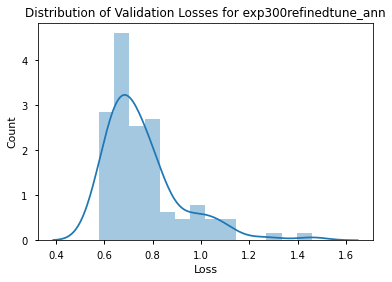

In [5]:
exp_name = "exp300refinedtune_ann"
tuner_dict = get_best_models(exp_name, num_models=100)

all_results = [tuner_dict[i]["results"]["val_loss"] for i in tuner_dict]

sb.distplot(all_results)
plt.title('Distribution of Validation Losses for ' + exp_name)
plt.xlabel('Loss')
plt.ylabel('Count')
plt.savefig(dir_settings['figure_tuner_directory'] + 'tuning_loss_dist_' + exp_name + '.png')

### Refining the best parameters for better tuning

In [50]:
exp_name = "exp401basetune_interp"
tuner_dict = get_best_models(exp_name, num_models=10)

if "interp" in exp_name:
    varnames = ["mask_l2", "prediction_model_nodes", "prediction_model_act", "interp_learning_rate"]
elif "ann_analog" in exp_name:
    varnames = ["ann_analog_input_l2", "ann_analog_model_nodes", "ann_analog_model_act", "ann_analog_learning_rate"]
elif "ann" in exp_name:
    varnames = ["ann_input_l2", "ann_model_nodes", "ann_model_act", "ann_learning_rate"]

for varname in varnames:
    params = []
    for i in tuner_dict:
        params.append(tuner_dict[i][varname])
    print(varname + ":", end='\n\n')
    print(np.unique(params), end = '\n\n')

    #print(params, end='\n\n')


mask_l2:

[0.]

prediction_model_nodes:

['[10, 10, 10]' '[100, 100]' '[100]' '[20, 20, 20]' '[50, 50, 50]'
 '[50, 50]' '[50]' '[5]']

prediction_model_act:

['elu' 'relu' 'tanh']

interp_learning_rate:

[0.0001 0.001  0.01  ]



### Identify the best "percentile_huber_d" for the analog problem

In [19]:
dir_settings = base_directories.get_directories()
metrics_directory = dir_settings["metrics_directory"]

experiment_group = 'exp301mse'

experiment_special = [experiment_group + ls for ls in ['-mae', '-mse']]
experiment_list = [experiment_group + "-huber" + str(hub) for hub in range(15, 105, 5)] + experiment_special
experiment_list = experiment_special

model_type_list = (
    "interp_model",
    "ann_model",
    "ann_analog_model"
)

all_metrics = {}

for experiment in experiment_list:
    for model_type in model_type_list:
        for fn in os.listdir(metrics_directory):
            if ("subset" in fn) and (experiment in fn) and (model_type in fn) and fn.endswith(".pickle"):
                with open(metrics_directory + fn, "rb") as fp:
                    if experiment not in experiment_special:
                        huber = int(experiment.split('huber')[-1])
                        all_metrics[fn] = dict()
                        all_metrics[fn]['error'] = pickle.load(fp)['error_network'].mean(axis=1)
                        all_metrics[fn]['experiment'] = experiment
                        all_metrics[fn]['model_type'] = model_type
                        all_metrics[fn]['huber'] = huber
                    else:
                        all_metrics[fn] = dict()
                        all_metrics[fn]['error'] = pickle.load(fp)['error_network'].mean(axis=1)
                        all_metrics[fn]['experiment'] = experiment
                        all_metrics[fn]['model_type'] = model_type
                        if 'mse' in fn.split('-')[1]:
                            all_metrics[fn]['huber'] = 120
                        else:
                            all_metrics[fn]['huber'] = 140

([<matplotlib.axis.XTick at 0x2b2720a60>,
 [Text(25, 0, '25'),
  Text(50, 0, '50'),
  Text(75, 0, '75'),
  Text(100, 0, '100'),
  Text(120, 0, 'MSE'),
  Text(140, 0, 'MAE')])

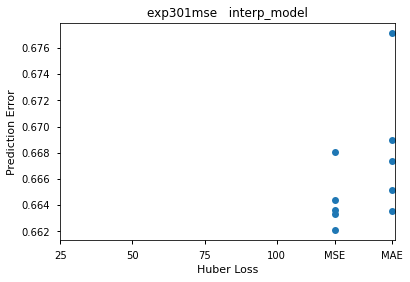

In [20]:
focus_on_model = "interp_model"

hubers = []
errors = []
for key in all_metrics.keys():
    if all_metrics[key]['model_type'] == focus_on_model:
        hubers.append(all_metrics[key]['huber'])
        errors.append(all_metrics[key]['error'])

plt.plot(hubers, errors, 'o')
plt.ylabel('Prediction Error')
plt.xlabel('Huber Loss')
plt.title(experiment_group + '   ' + focus_on_model)
plt.xticks([25, 50, 75, 100, 120, 140], [25, 50, 75, 100, "MSE", "MAE"])
#plt.savefig(dir_settings["figure_directory"] + ,'huber_test/' + experiment_group + '_' + focus_on_model + '.png')
    

In [26]:
import numpy as np
metrics = np.zeros((5,5))

metrics[0,2] = 1

<AxesSubplot:>

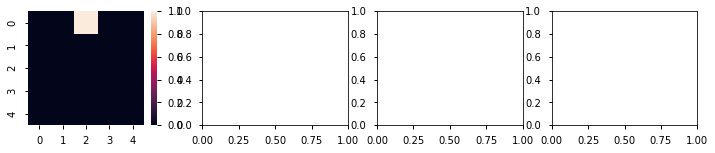

In [27]:
import seaborn as sb
fig, axs = plt.subplots(1, 4, figsize=(12, 2.1))
ax = axs[0]
sb.heatmap(metrics, ax=ax)


In [31]:
np.array([0.0001, 0.01, .1, 1.1, 2.33333]).round(2)

array([0.  , 0.01, 0.1 , 1.1 , 2.33])